# Face verification

### Goals
- train a network for face similarity using siamese networks
- train a network for face similarity using triplet loss

the architecture is as follows:

_image_

### Dataset

- We will be using Labeled Faces in the Wild (LFW) dataset available openly at _url_
- For computing purposes, we'll only restrict ourselves to a subpart of the dataset. You're welcome to train on the whole dataset on GPU
- We will also load pretrained weights


In [13]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Gopala KR 
last updated: 2018-03-04 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5


In [14]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

In [15]:
import keras
import os
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Concatenate, merge, Lambda, Dot
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Processing the dataset

The dataset consists of folders corresponding to each identity. The folder name is the name of the person.
We map each class (identity) to an integer id, and build mappings as dictionaries `name_to_classid` and `classid_to_name`

In [16]:
#PATH = "lfw-a/lfw/"
PATH = "lfw/lfw-deepfunneled/"

In [17]:
dirs = sorted(os.listdir(PATH))
name_to_classid = {d:i for i,d in enumerate(dirs)}
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: "+str(num_classes))

number of classes: 5749


In each directory, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries:
- mappings from imagepath and image id: `path_to_id` and `id_to_path`
- mappings from class id to image ids: `classid_to_ids` and `id_to_classid`

In [18]:
# read all directories
img_paths = {c:[directory + "/" + img for img in sorted(os.listdir(PATH+directory))] 
             for directory,c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v:k for k,v in enumerate(all_images_path)}
id_to_path = {v:k for k,v in path_to_id.items()}

In [19]:
# build mappings between images and class
classid_to_ids = {k:[path_to_id[path] for path in v] for k,v in img_paths.items()}
id_to_classid = {v:c for c,imgs in classid_to_ids.items() for v in imgs}
dict(list(id_to_classid.items())[0:13])

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 6,
 10: 7,
 11: 7,
 12: 8}

The following histogram shows the number of images per class: there are many classes with only one image. 
These classes are useful as negatives, only as we can't make a positive pair with them.

In [20]:
[(classid_to_name[x], len(classid_to_ids[x])) for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53)]

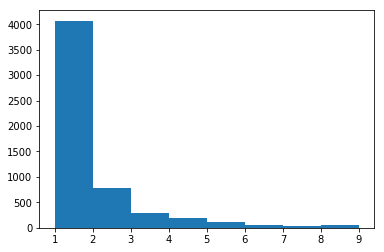

In [21]:
plt.hist([len(v) for k,v in classid_to_ids.items()], bins=range(1,10))
plt.show()

In [22]:
[(classid_to_name[x], len(classid_to_ids[x])) for x in np.argsort([len(v) for k,v in classid_to_ids.items()])[::-1][:10]]

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53)]

### siamese nets

A siamese net takes as input two images $x_1$ and $x_2$ and outputs a single value which corresponds to the similarity between $x_1$ and $x_2$.

In order to train such a system, one has to build positive and negative pairs for the training. 

In [23]:
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j]) for i in range(len(imgs)) for j in range(i+1,len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

def build_neg_pairs_for_id(classid, classes, max_num=20):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)
    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

Let's build positive and a negative pairs for class 5

In [24]:
build_pos_pairs_for_id(5, 20)

[(5, 7), (7, 8), (5, 8), (5, 6), (6, 8), (6, 7)]

In [25]:
build_neg_pairs_for_id(5, list(range(num_classes)), 6)

[(7, 6220), (8, 288), (6, 2150), (8, 6515), (7, 3550), (7, 3544)]

Now that we have a way to compute the pairs, let's open all the possible images. It will expand all the images into RAM memory. There are more than 1000 images, so 250Mo of RAM will be used, which will not cause any issue.

_Note: if you plan on opening more images, you should not open them all at once, and rather build a generator_

In [26]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')[20:80,20:80,:]

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(PATH+path)),0)]
    return np.vstack(all_imgs)


In [ ]:
all_imgs = open_all_images(id_to_path)
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

In [ ]:
def build_train_test_data(split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(listX1)
    X1_ids_train, X2_ids_train, Y_ids_train = np.array(listX1)[perm], np.array(listX2)[perm], np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    #test
    for id in range(split,num_classes):
        pos = build_pos_pairs_for_id(id)
        neg = build_neg_pairs_for_id(id, list(range(split,num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test, X2_ids_test, Y_ids_test = np.array(listX1), np.array(listX2), np.array(listY)
    return X1_ids_train, X2_ids_train, Y_ids_train, X1_ids_test, X2_ids_test, Y_ids_test

In [ ]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 0.5)), # blur images with a sigma of 0 to 3.0
    iaa.Multiply((0.5, 1.5))
])


In [ ]:
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data()

In [ ]:
class Generator():
    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.cur_train_index=0
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            imgs1 = self.X1[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs2 = self.X2[self.cur_train_index:self.cur_train_index+self.batch_size]
    
       # deactivate augmentation
       #     yield ([self.imgs[imgs1], self.imgs[imgs2]],
       #             self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])
        
            yield ([seq.augment_images(self.imgs[imgs1]), 
                    seq.augment_images(self.imgs[imgs2])
                    ],
                    self.Y[self.cur_train_index:self.cur_train_index+self.batch_size]
                )

In [ ]:
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)

In [ ]:
[x1, x2], y = next(gen.next_train())

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')
plt.show()

In [ ]:
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]

In [ ]:
test_X1.shape, test_X2.shape, test_Y.shape

## Simple convolutional model

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 0.25
    #return K.mean(K.maximum(y_true * y_pred, 0.), axis=-1)
    
    return K.mean( y_true * K.square(1 - y_pred) +
                  (1 - y_true) * K.square(K.maximum(y_pred - margin, 0)))

    #return K.mean( K.square(y_true - y_pred)

In [ ]:
def accuracy_sim(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on similarity.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [ ]:
inp = Input((60,60,3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 30,30
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 15,15
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 8,8
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(50)(x)
shared_conv = Model(inputs=inp, outputs = x)

In [ ]:
shared_conv.summary()

In [ ]:
i1 = Input((60,60,3), dtype='float32')
i2 = Input((60,60,3), dtype='float32')

x1 = shared_conv(i1)
x2 = shared_conv(i2)

out = Dot(axes=-1, normalize=True)([x1,x2])

model = Model(inputs=[i1, i2], outputs=out)
predict_model = Model(inputs=i1, outputs=x1)
model.compile(loss=contrastive_loss, optimizer="rmsprop", metrics=[accuracy_sim])

In [ ]:
model.fit_generator(generator=gen.next_train(), 
                    steps_per_epoch=train_Y.shape[0] // 32, 
                    epochs=5,
                    validation_data=([test_X1, test_X2], test_Y))

In [ ]:
shared_conv.summary()

In [ ]:
model.save_weights("weights.h5")

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

In [ ]:
model.fit(x=[train_X1, train_X2],
          y=train_Y,
          epochs=10, batch_size=10)


In [ ]:
emb = predict_model.predict(all_imgs)

In [ ]:
norm_emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)


In [ ]:
preds = model.predict([test_X1, test_X2])
compute_accuracy(test_Y, preds)

In [ ]:
def most_sim(x, emb, topn=5):
    sims = np.dot(emb,x)
    ids = np.argsort(sims)[::-1]
    return [(id,sims[id]) for id in ids[:topn]]

In [ ]:
def test_id(image, emb, topn=5):
    sims = np.dot(emb,x)
    ids = np.argsort(sims)[::-1]
    return [(id,sims[id]) for id in ids[:topn]]

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.show()

In [ ]:
interesting_classes = list(filter(lambda x: len(x[1])>4, classid_to_ids.items()))
class_idx = random.choice(interesting_classes)[0]
print(class_idx)
img_idx = random.choice(classid_to_ids[class_idx])
for id, sim in most_sim(norm_emb[img_idx], norm_emb):
    display(all_imgs[id])
    print((classid_to_name[id_to_classid[id]], id, sim))

# Triplet loss

In the triplet loss model, we'll define 3 inputs $(a,+,-)$ for anchor, positive and negative.

#### usage and differences with siamese nets

We release the hard constraint that all data of the same class should be squashed to a single point. Rather, they can live on a manifold, as long as they are closer to similar class than 

In [ ]:
def build_positive_pairs(split=0.8):
    listX1 = []
    listX2 = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_for_id(id)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
    perm = np.random.permutation(listX1)
    return np.array(listX1)[perm], np.array(listX2)[perm]

In [ ]:
Xa_train, Xp_train = build_positive_pairs()

In [ ]:
Xa_train.shape, Xp_train.shape

In [ ]:
class TripletGenerator():
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, max_positives=20):
        self.cur_img_index=0
        self.cur_img_pos_index=0
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train
        self.Xp = Xp_train
        self.cur_train_index = 0
        self.num_samples = Xa_train.shape[0]
        self.all_imgs_idx = list(range(all_imgs.shape[0]))
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            # fill one batch
            imgs_a = self.Xa[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_p = self.Xp[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_n = random.sample(self.all_imgs_idx,imgs_a.shape[0])
       # deactivate augmentation
       #     yield ([self.imgs[imgs1], self.imgs[imgs2]],
       #             self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])
        
            yield ([seq.augment_images(self.imgs[imgs_a]), 
                    seq.augment_images(self.imgs[imgs_p]),
                    seq.augment_images(self.imgs[imgs_n])
                    ],
                    np.zeros(shape=(imgs_a.shape[0]))
                )


In [ ]:
gen = TripletGenerator(Xa_train, Xp_train, 32, all_imgs)

In [ ]:
[xa, xp, xn], y = next(gen.next_train())

In [ ]:
plt.figure(figsize=(16, 9))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.title("anchor")
    plt.imshow(xa[i] / 255)
    plt.axis('off')
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.title("positive")
    plt.imshow(xp[i] / 255)
    plt.axis('off')
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.title("negative")
    plt.imshow(xn[i] / 255)
    plt.axis('off')
plt.show()

In [ ]:

def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)


def triplet_loss(X):
    _alpha = 0.2
    a, p, n = X

    positive_distances = K.mean(K.square(a - p),axis=-1)
    negative_distances = K.mean(K.square(a - n),axis=-1)
    
    # batch loss
    losses = K.maximum(0.0, positive_distances - negative_distances + _alpha)
    
    return K.mean(losses)

In [ ]:
NormalizeLayer = Lambda(lambda x: K.l2_normalize(
                        K.sqrt(K.relu(x) + K.epsilon()) - K.sqrt(K.relu(-x)+ K.epsilon()),
                        axis=-1))

In [ ]:
inp = Input((60,60,3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 30,30
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 15,15
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x) # 8,8
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(50)(x)
shared_conv2 = Model(inputs=inp, outputs = x)

### tech details 

In [ ]:
anchor = Input((60, 60, 3), name='anchor')
positive = Input((60, 60, 3), name='positive')
negative = Input((60, 60, 3), name='negative')

a = shared_conv2(anchor)
p = shared_conv2(positive)
n = shared_conv2(negative)

loss = Lambda(triplet_loss,
                      output_shape=(1,))(
                      [a,p,n])

model_triplet = Model(
    inputs=[anchor, positive, negative],
    outputs=loss)

predict_model_triplet = Model(inputs=anchor, outputs=a)
model_triplet.compile(loss=identity_loss, optimizer="adam")

In [ ]:
model_triplet.fit_generator(generator=gen.next_train(), 
                    steps_per_epoch=Xa_train.shape[0] // 32, 
                    epochs=5)

In [ ]:
emb = predict_model_triplet.predict(all_imgs)

In [ ]:
norm_emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [ ]:
def most_sim(x, emb, topn=5):
    sims = np.dot(emb,x)
    ids = np.argsort(sims)[::-1]
    return [(id,sims[id]) for id in ids[:topn]]

In [ ]:
def test_id(image, emb, topn=5):
    sims = np.dot(emb,x)
    ids = np.argsort(sims)[::-1]
    return [(id,sims[id]) for id in ids[:topn]]

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.show()

In [ ]:
interesting_classes = list(filter(lambda x: len(x[1])>4, classid_to_ids.items()))
class_idx = random.choice(interesting_classes)[0]
print(class_idx)
img_idx = random.choice(classid_to_ids[class_idx])
for id, sim in most_sim(norm_emb[img_idx], norm_emb):
    display(all_imgs[id])
    print((classid_to_name[id_to_classid[id]], id, sim))

Todo 
- compute ROC AuC
- Hard negative mining
- pretrained model
- exercises